In [25]:
import numpy as np
import matplotlib.pyplot as plt

In [26]:
#Algoritmo de triangulação
def incr_triangles(lpontos):
    lpontos.sort()
    lpontos=list(np.array(lpontos))
    lcasco=lpontos[:3]
    edges=[[lpontos[0],lpontos[2]]]
    for i in range(3):
        edges.append([lpontos[i+1],lpontos[i]])
    if np.cross(lcasco[0]-lcasco[-1],lcasco[1]-lcasco[0])<0: #se lcasco for horário
            lcasco=[lcasco[0]]+lcasco[1::][::-1] # vira antihorário
    triangs=[lcasco.copy()]
    for i,ponto in enumerate(lpontos[3:]):
        i+=3
        iposits=[]
        for j,p in enumerate(lcasco):
            vet=np.cross(ponto-lcasco[j-1],p-lcasco[j-1])
            if vet>=0:
                iposits.append(j)
        if 0 not in iposits:
            p0=iposits[0]
            index=iposits[-1]
            triangs.append([lcasco[index],lcasco[index-1],ponto])#tratamos esse a parte pois não retiramos do lcasco
            for index in iposits[:-1][::-1]: 
                triangs.append([lcasco[index],lcasco[index-1],ponto])
                lcasco.pop(index)
        elif len(iposits)==1:
            p0=len(lcasco)
            triangs.append([lcasco[-1],ponto,lcasco[0]])
        else:
            p0=iposits[1]
            triangs.append([lcasco[0],lcasco[-1],ponto])
            for index in iposits[1:][::-1]: 
                triangs.append([lcasco[index],lcasco[index-1],ponto])
                lcasco.pop(index)
        lcasco.insert(p0,ponto)
    return triangs #não repeti o primeiro ponto como no arquivo original 

In [27]:
def delaunay(triangs):
    tup_tri=[tuple([tuple(t1) for t1 in triang]) for triang in triangs] #lista de triangs de tuplas
    d={ttriang:[] for ttriang in tup_tri}
    for ttriang in tup_tri: #achar o vizinhos
        l_tviz=tup_tri.copy()
        l_tviz.remove(ttriang)
        striang=set(ttriang)
        
        l_tviz=[viz for viz in l_tviz if len(striang.intersection(viz))>1]
        d[ttriang]=l_tviz # lista de vizinhos de ttriang
    def iterar(d):
        for tkey in d.keys():
            for tri in d[tkey]: # tri é vizinho de tkey
                f=flip(list(np.array(tkey)),list(np.array(tri)))
                d[tkey].remove(tri)
                d[tri].remove(tkey)
                if f[0]: # flip ocorrer
                    tri3,tri4=[tuple([tuple(t) for t in triang]) for triang in f[1]]
                    d[tri3]=[]
                    d[tri4]=[]
                    for viz in d[tkey]:
                        d[viz].remove(tkey)
                        sviz=set(viz) #set das tuplas do vizinho
                        if len(sviz.intersection(tri3))>1:
                            d[tri3].append(viz)
                            d[viz].append(tri3)
                        else: 
                            d[tri4].append(viz)
                            d[viz].append(tri4)
                    for viz in d[tri]:
                        d[viz].remove(tri)
                        sviz=set(viz)
                        if len(sviz.intersection(tri3))>1:
                            d[tri3].append(viz)
                            d[viz].append(tri3)
                        else: 
                            d[tri4].append(viz)
                            d[viz].append(tri4)
                    d.pop(tkey)
                    d.pop(tri)
                    iterar(d)
                    return
    iterar(d)        
    # d.values() deve ser []s
    t_delaunay=[list(np.array(k)) for k in d.keys()] # novos triangs
    return t_delaunay

In [28]:
def flip(tri1,tri2):
    for i,l in enumerate([tri1,tri2]):        
        if np.cross(l[-1]-l[0],l[1]-l[0])<0: #se l for antihor
            l.reverse() # vira horário
    tt1,tt2=set([tuple(t1) for t1 in tri1]), set([tuple(t1) for t1 in tri2]) # set de tuplas de tri1 e tri2
    a,b=tt1.intersection(tt2)
    c,d=tt1.symmetric_difference(tt2)
    quad=list(np.array([a,c,b,d]))
    if np.cross(quad[-1]-quad[0],quad[1]-quad[0])<0: #se quad for antihor
            quad=quad[::-1] # vira horário
    for i,ponto in enumerate(quad):
        mods=np.linalg.norm((quad[i-2]-quad[i-1]))*np.linalg.norm((ponto-quad[i-1]))
        vet=np.cross((quad[i-2]-quad[i-1]),(ponto-quad[i-1]))
        ang=np.arcsin(vet/mods)
        if ang<0: #quadrilatero é côncavo
            return (False,(tri1,tri2))
    angs0=[]  
    for triang in tri1,tri2:
        for i,ponto in enumerate(triang):
            mods=np.linalg.norm((triang[i-2]-triang[i-1]))*np.linalg.norm((ponto-triang[i-1]))
            esc=np.dot((ponto-triang[i-1]),(triang[i-2]-triang[i-1]))
            ang=np.arccos(esc/mods) # arccos sempre retorna 0<ang<pi
            angs0.append(ang)
    tri3,tri4=[quad[1],quad[2],quad[3]],[quad[3],quad[0],quad[1]]
    angs3=[]
    for triang in tri3,tri4:
        for i,ponto in enumerate(triang):
            mods=np.linalg.norm((triang[i-2]-triang[i-1]))*np.linalg.norm((ponto-triang[i-1]))
            esc=np.dot((ponto-triang[i-1]),(triang[i-2]-triang[i-1]))
            ang=np.arccos(esc/mods)
            angs3.append(ang)
    angs0.sort()
    angs3.sort()
    for i,ang in enumerate(angs0):
        if ang>angs3[i]:
            return (False,(tri1,tri2))
        elif ang<angs3[i]: return (True,(tri3,tri4))
    return (False,(tri1,tri2))

In [38]:
lpontos=[[3,3],[4.5,6],[4,10],[3.7,7.3],[7,2],[5.6,7.3],[6,11],[2,10],[8,5]]        
inct=incr_triangles(lpontos)
dl=delaunay(inct)

In [50]:
def inctplotar(lpontos): # plota a triangulação sem flips
    inct=incr_triangles(lpontos)
    apontos=np.array(lpontos).T
    for triang in inct:
        atri=np.array(triang+[triang[0]]).T
        plt.plot(atri[0],atri[1])
    plt.scatter(apontos[0],apontos[1])
    plt.axis('equal')
    plt.show()

def dlplotar(lpontos):  # plota a triangulção delaunay  
    inct=incr_triangles(lpontos)
    dl=delaunay(inct)
    apontos=np.array(lpontos).T
    for triang in dl:
        adl=np.array(triang+[triang[0]]).T
        plt.plot(adl[0],adl[1])
    plt.scatter(apontos[0],apontos[1])
    plt.title("delaunay")
    plt.axis('equal')
    plt.show()

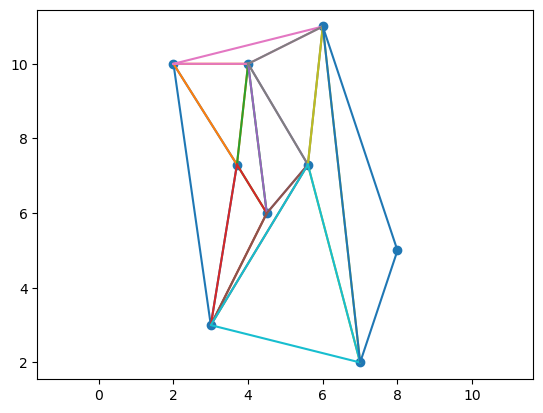

In [48]:
inctplotar(lpontos)

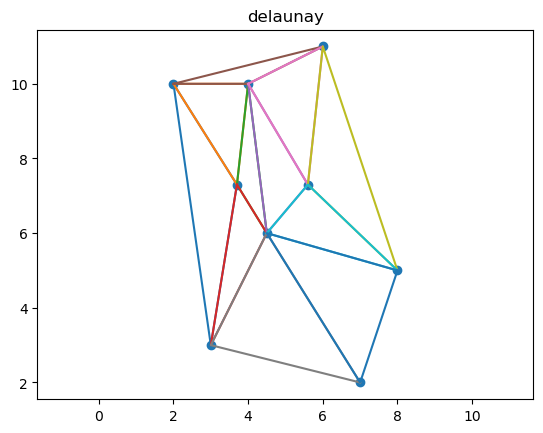

In [49]:
dlplotar(lpontos)